# Project: Peruvian Banknote Classification with EfficientNet

**Key Highlights**

- Dataset: 9,315 high-quality images of Peruvian banknotes (10, 20, 50, 100 soles) from both old and new families, including obverse/reverse sides, captured under diverse lighting, angles, and occlusion. 16 classes in total to clasify. 

- Model: Fine-tuned EfficientNetB0 with data augmentation (rotations, flips, brightness adjustments) to handle real-world variability.

- Performance: Achieved 92% validation accuracy, outperforming ResNet50, VGG16, and a custom CNN architecture. 

- Impact: A scalable solution for financial institutions, ATMs, and accessibility tools for visually impaired individuals.

## Global Configurations and data loading  

In [2]:
# Standard Python libraries
import os
import time
import math
import logging
from collections import Counter, defaultdict
from functools import lru_cache
import random

# Data manipulation and visualization
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import pandas as pd

# Machine learning and metrics
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    roc_auc_score,
    roc_curve,
    auc,
    classification_report,
    confusion_matrix,
)
from sklearn.preprocessing import label_binarize
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Image processing
from skimage import filters

# PyTorch core
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Subset

# PyTorch vision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
from torch.nn.functional import softmax

# Progress bar
from tqdm import tqdm


In [3]:
 
# Configure logging
logging.basicConfig(level=logging.INFO, format='%(message)s')
logger = logging.getLogger()

# =============================================
# Global Configurations and Constants
# =============================================
SEED = 42
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

BASE_PATH = "/Users/elvisrojasmonguia/Documents/Python courses/Projects/Peruvian banknotes/data/"
DATA_SPLITS = ["training_set", "validation_set", "testing_set"]
MODEL_SAVE_DIR = "models"
NUM_CLASSES = 16
BATCH_SIZE = 32
NUM_EPOCHS = 50
NUM_WORKERS = 0  # Optimized for Apple Silicon
EARLY_STOPPING_PATIENCE = 5
GRADIENT_CLIP = 1.0

# Normalization constants
NORMALIZATION_MEAN = [0.485, 0.456, 0.406]
NORMALIZATION_STD = [0.229, 0.224, 0.225]
IMAGE_SIZE = (224, 224)

# =============================================
# Transformation Configurations (CHANGED: optimized augmentations)
# =============================================
def get_train_transforms(apply_augmentation):
    base = [
        transforms.Resize(IMAGE_SIZE),
        transforms.ToTensor(),
        transforms.Normalize(NORMALIZATION_MEAN, NORMALIZATION_STD)
    ]
    
    if apply_augmentation:
        return transforms.Compose([
            transforms.RandomRotation(15),
            transforms.RandomHorizontalFlip(p=0.3),
            transforms.ColorJitter(brightness=0.2, contrast=0.2),
            transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
            *base
        ])
    return transforms.Compose(base)

def get_validation_transforms():
    return transforms.Compose([
        transforms.Resize(IMAGE_SIZE),
        transforms.ToTensor(),
        transforms.Normalize(NORMALIZATION_MEAN, NORMALIZATION_STD)
    ])

# =============================================
# Enhanced Data Loading with Caching (CHANGED: added class weights)
# =============================================
@lru_cache(maxsize=2)
def load_datasets_cached(apply_augmentation):
    """Load datasets with class weight calculation"""
    train_dataset = datasets.ImageFolder(
        os.path.join(BASE_PATH, DATA_SPLITS[0]),
        transform=get_train_transforms(apply_augmentation)
    )
    
    # Calculate class weights
    class_counts = np.bincount([label for _, label in train_dataset])
    class_weights = 1. / class_counts
    class_weights = torch.tensor(class_weights, dtype=torch.float32)
    
    return {
        "train": DataLoader(
            train_dataset,
            batch_size=BATCH_SIZE,
            shuffle=True,
            num_workers=NUM_WORKERS,
            pin_memory=True
        ),
        "validation": DataLoader(
            datasets.ImageFolder(
                os.path.join(BASE_PATH, DATA_SPLITS[1]),
                transform=get_validation_transforms()
            ),
            batch_size=BATCH_SIZE,
            shuffle=False,
            num_workers=NUM_WORKERS,
            pin_memory=True
        ),
        "test": DataLoader(
            datasets.ImageFolder(
                os.path.join(BASE_PATH, DATA_SPLITS[2]),
                transform=get_validation_transforms()
            ),
            batch_size=BATCH_SIZE,
            shuffle=False,
            num_workers=NUM_WORKERS,
            pin_memory=True
        )
    }, class_weights


## Exploratory data analysis

In [257]:
# Cargar datasets con y sin aumentación
data_loaders_aug, _     = load_datasets_cached(apply_augmentation=True)
data_loaders_no_aug, _  = load_datasets_cached(apply_augmentation=False)

In [258]:
def get_class_samples(dataset, num_samples=1):
    """Gets unique samples per class"""
    class_indices = defaultdict(list)
    for idx, (_, label) in enumerate(dataset):
        class_indices[label].append(idx)
    
    selected_indices = []
    for cls in sorted(class_indices.keys()):
        selected_indices.extend(class_indices[cls][:num_samples])
    
    return selected_indices

# Get indices of 1 sample per class
class_names = data_loaders_no_aug['train'].dataset.classes
sample_indices = get_class_samples(data_loaders_no_aug['train'].dataset)

# Create Subsets with selected samples
subset_no_aug = Subset(data_loaders_no_aug['train'].dataset, sample_indices)
subset_aug = Subset(data_loaders_aug['train'].dataset, sample_indices)

# Create DataLoaders without shuffle
sample_loader_no_aug = DataLoader(subset_no_aug, batch_size=16, shuffle=False)
sample_loader_aug = DataLoader(subset_aug, batch_size=16, shuffle=False)

# Get batches
orig_images, orig_labels = next(iter(sample_loader_no_aug))
aug_images, aug_labels = next(iter(sample_loader_aug))

def plot_samples(images, labels, title, class_names):
    """4x4 visualization for 16 classes"""
    plt.figure(figsize=(16, 8))
    
    # Adjust subplots
    plt.subplots_adjust(wspace=0.2, hspace=0.4)
    
    for i in range(16):
        plt.subplot(4, 4, i + 1)
        img = images[i].numpy().transpose(1, 2, 0)
        img = img * NORMALIZATION_STD + NORMALIZATION_MEAN
        plt.imshow(np.clip(img, 0, 1))
        plt.title(class_names[labels[i]], fontsize=10)
        plt.axis('off')
    
    plt.suptitle(title, fontsize=16)
    plt.show()


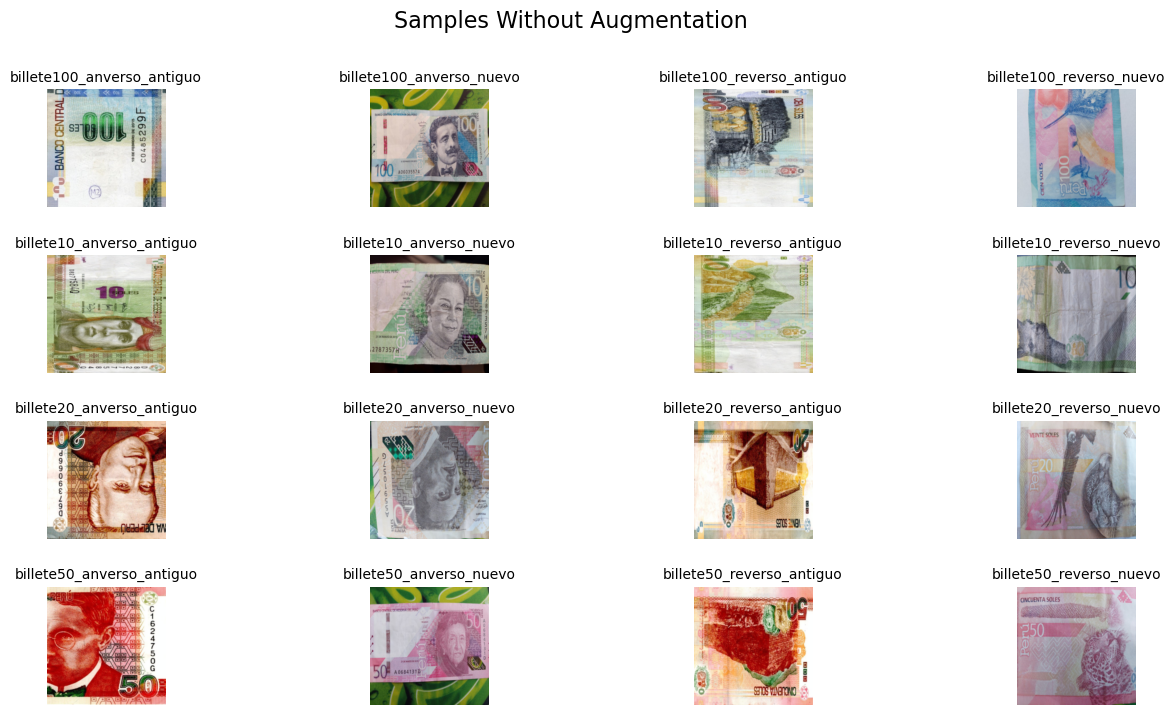

In [260]:
#Visualize samples without augmentation
plot_samples(orig_images, orig_labels, "Samples Without Augmentation", class_names)
 

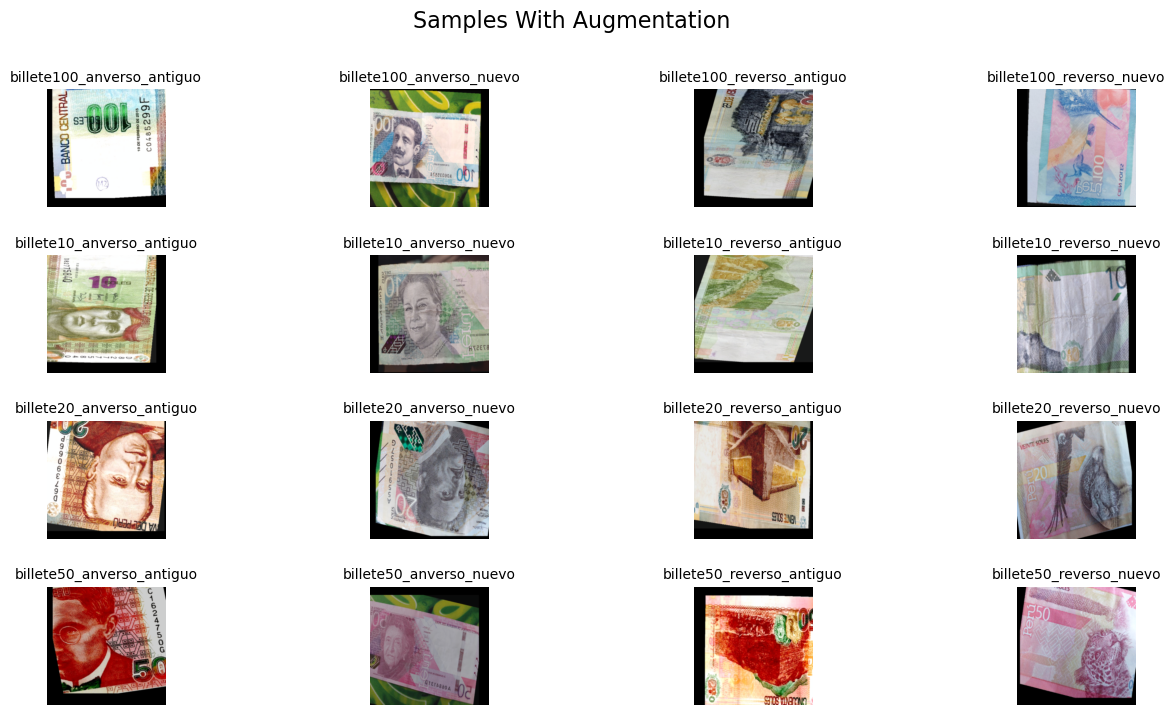

In [267]:
#Visualize samples with augmentation
plot_samples(aug_images, aug_labels, "Samples With Augmentation", class_names)

In [275]:
# Function to plot random images per class
def plot_random_images_per_class(dataset, class_names, mean, std, n_rows=4, n_cols=4, fig_size_tup=(12, 12)):
    # Create a list to store one image per class
    images_per_class = []
    labels_per_class = []
    file_names_per_class = []

    # Select a random image from each class
    for class_idx in range(len(class_names)):
        # Get all image indices for this class
        class_indices = [i for i, (_, label) in enumerate(dataset.samples) if label == class_idx]
        
        # Select a random index
        random_idx = random.choice(class_indices)
        
        # Get the image, label, and file name
        image, label = dataset[random_idx]
        file_name = dataset.samples[random_idx][0]
 
        # Save the image, label, and file name
        images_per_class.append(image)
        labels_per_class.append(label)
        file_names_per_class.append(file_name)

    # Create the figure and subplots
    fig, axes = plt.subplots(n_rows, n_cols, figsize=fig_size_tup)
    fig.suptitle('Images from Each Class with Normalization', fontsize=16)

    # Display the images in the grid
    for i, (image, label, file_name) in enumerate(zip(images_per_class, labels_per_class, file_names_per_class)):
        ax = axes[i // n_cols, i % n_cols]
        
        # Convert the tensor to a PIL image for visualization
        if isinstance(image, torch.Tensor):
            # Ensure the image has only 3 channels (RGB)
            if image.shape[0] > 3:
                image = image[:3, :, :]
            image = transforms.ToPILImage()(image)
        
        # Display the image
        ax.imshow(image)
        ax.set_title(f"{class_names[label]}\n{file_name.split('/')[-1]}", fontsize=10)
        ax.axis('off')

    # Adjust spacing
    plt.tight_layout()
    plt.show()

 

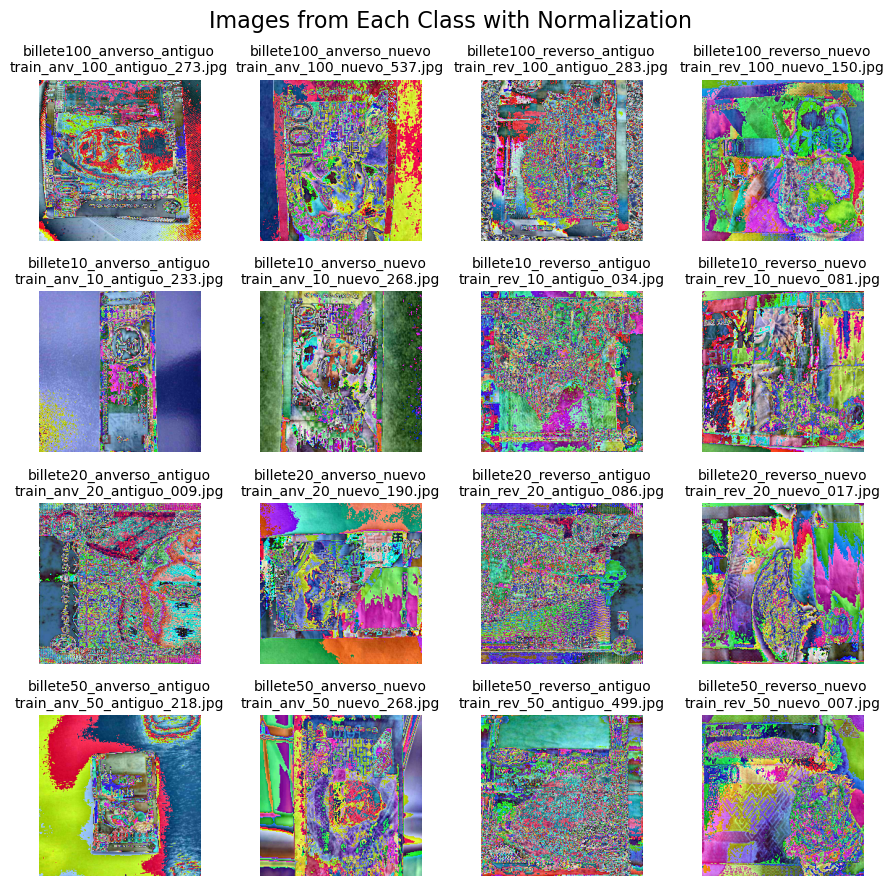

In [277]:

# Execute the function
plot_random_images_per_class(
    data_loaders_no_aug['train'].dataset, 
    data_loaders_no_aug['train'].dataset.classes, 
    NORMALIZATION_MEAN, 
    NORMALIZATION_STD, 
    fig_size_tup=(9, 9)
)

In [281]:
def plot_class_distribution(dataset, title, fig_size_tup=(10, 6)):
    """Analyze and visualize the class distribution"""
    class_counts = Counter(dataset.targets)
    class_names = dataset.classes
    
    plt.figure(figsize=fig_size_tup)
    bars = plt.bar(class_names, [class_counts[i] for i in range(len(class_names))], color='skyblue', edgecolor='black')
    plt.title(f'Class Distribution - {title}', fontsize=16, weight='bold')
    plt.xticks(rotation=45, ha='right', fontsize=12)
    plt.ylabel('Number of Images', fontsize=12)
    plt.xlabel('Classes', fontsize=12)
    
    # Add percentages
    total = sum(class_counts.values())
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                 f'{height/total:.1%}',
                 ha='center', va='bottom', fontsize=10)
    
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

 

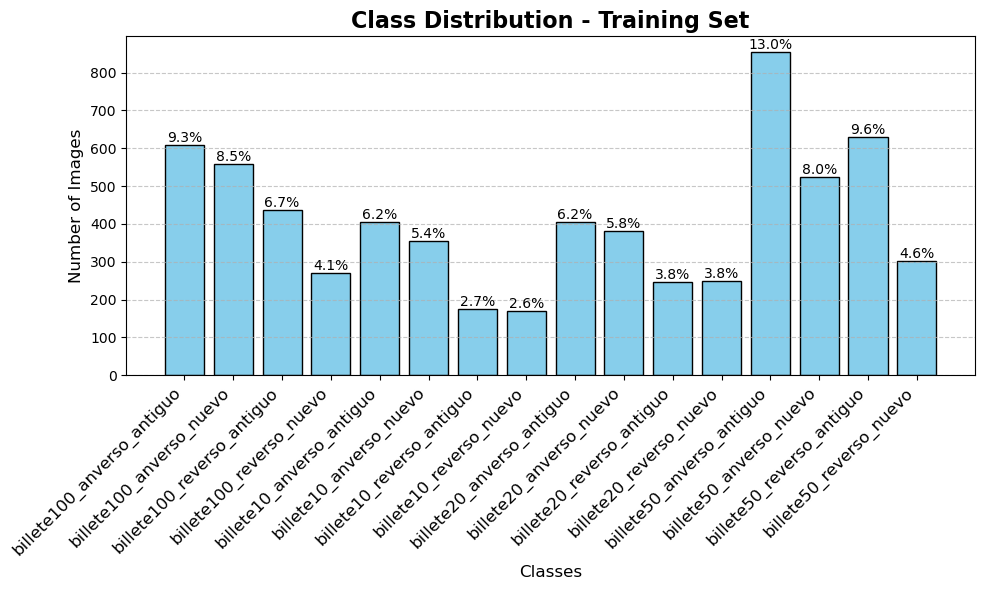

In [285]:

# Execute the function
plot_class_distribution(data_loaders_no_aug['train'].dataset, 'Training Set')


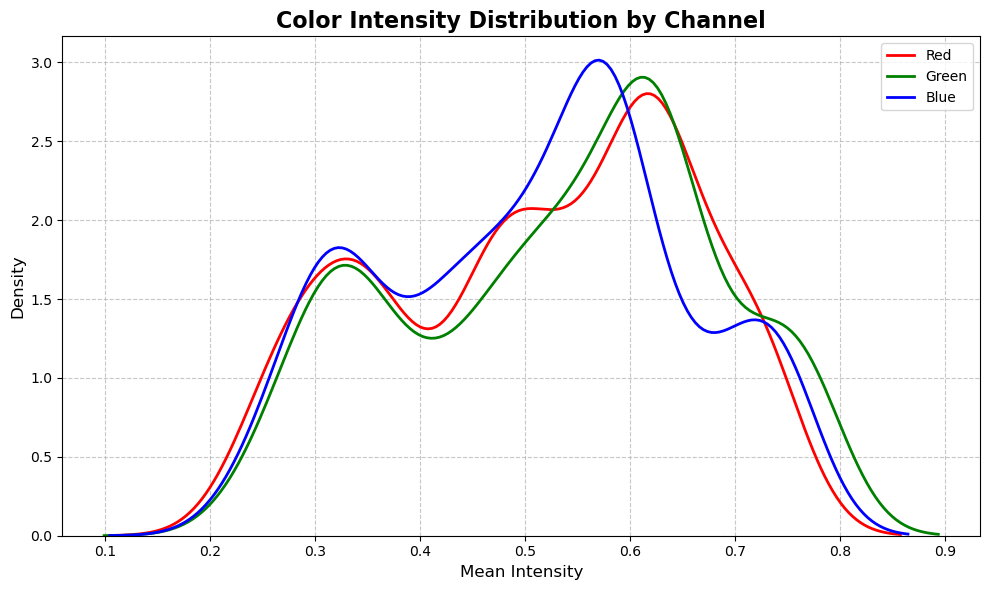

In [287]:
def plot_color_distribution(dataset, fig_size_tup=(10, 6)):
    """Analyzes the color distribution in the dataset"""
    channel_means = []
    
    for img_path, _ in dataset.imgs[:500]:  # Representative sample
        img = plt.imread(img_path)/255.0
        channel_means.append(img.mean(axis=(0, 1)))
    
    channel_means = np.array(channel_means)
    
    plt.figure(figsize=fig_size_tup)
    for i, (color, color_label) in enumerate(zip(['red', 'green', 'blue'], ['Red', 'Green', 'Blue'])):
        sns.kdeplot(channel_means[:, i], label=color_label, color=color, linewidth=2)
    plt.title('Color Intensity Distribution by Channel', fontsize=16, weight='bold')
    plt.xlabel('Mean Intensity', fontsize=12)
    plt.ylabel('Density', fontsize=12)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# Execute the function
plot_color_distribution(data_loaders_no_aug['train'].dataset, fig_size_tup=(10, 6))


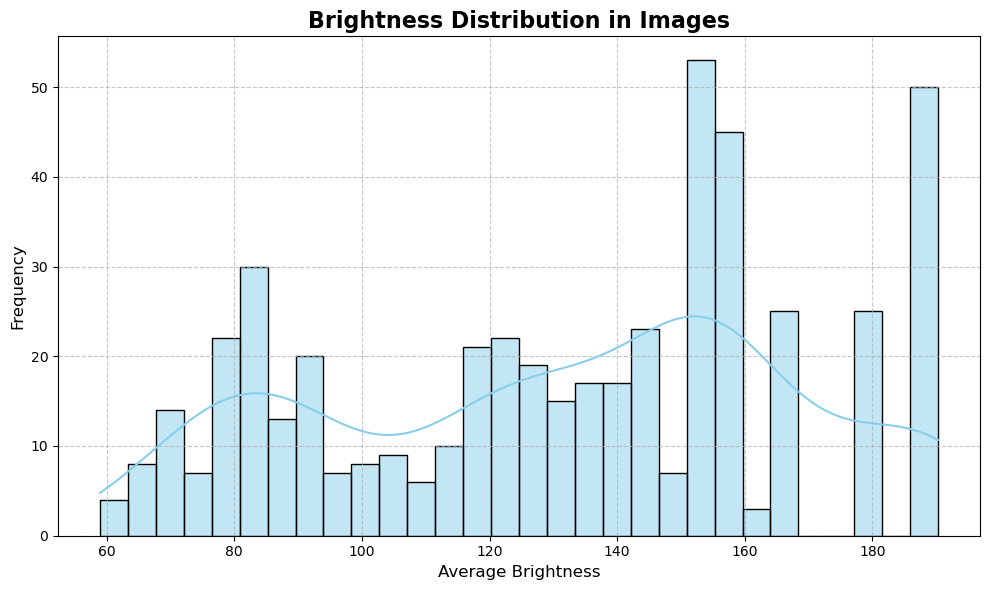

In [291]:
 
def analyze_brightness(dataset, fig_size_tup=(10, 6)):
    """Analyzes the brightness distribution in the images"""
    brightness_values = []
    
    for img_path, _ in dataset.imgs[:500]:  # Representative sample
        img = plt.imread(img_path)
        if img.ndim == 3:
            img = img.mean(axis=2)  # Convert to grayscale
        brightness_values.append(img.mean())
    
    plt.figure(figsize=fig_size_tup)
    sns.histplot(brightness_values, bins=30, kde=True, color='skyblue', edgecolor='black')
    plt.title('Brightness Distribution in Images', fontsize=16, weight='bold')
    plt.xlabel('Average Brightness', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()


# Execute the function
analyze_brightness(data_loaders_no_aug['train'].dataset, fig_size_tup=(10, 6))


## Training and evaluation of the models

In [6]:
##### # =============================================
# Model Configurations
# =============================================
MODEL_CONFIGS = {
    "VGG": {
        "unfreeze_layers": ['features.24', 'classifier.0', 'classifier.3'],
        "optimizer": {
            "lr": 1e-4,
            "weight_decay": 1e-4
        }
    },
    "EfficientNet": {
        "unfreeze_layers": ['features.5', 'features.8', 'classifier.1'],
        "optimizer": {
            "lr": 1e-4,
            "weight_decay": 1e-4
        }
    },
    "ResNet": {
        "unfreeze_layers": ['layer4.2', 'fc'],
        "optimizer": {
            "lr": 1e-4,
            "weight_decay": 1e-4
        }
    },
    "CNN224x224": {
        "optimizer": {
            "lr": 0.001,
            "weight_decay": 0
        }
    }
}

# =============================================
# Model Architectures 
# =============================================
class CNN224x224(nn.Module):
    def __init__(self, num_classes=16):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(256, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((14, 14))
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(512*14*14, 512),  
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        return self.classifier(x)

class SimpleVGG(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        base = models.vgg16_bn(weights=models.VGG16_BN_Weights.DEFAULT)
        
        # Freeze all parameters first
        for param in base.parameters():
            param.requires_grad = False
            
        # Unfreeze specified layers
        for layer in MODEL_CONFIGS["VGG"]["unfreeze_layers"]:
            parts = layer.split('.')
            module = getattr(base, parts[0])
            if isinstance(module, nn.Sequential):
                for param in module[int(parts[1])].parameters():
                    param.requires_grad = True
        
        # Modified classifier
        base.classifier = nn.Sequential(
            nn.Linear(512*7*7, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )
        self.model = base

    def forward(self, x):
        return self.model(x)

# =============================================
# Callback System  
# =============================================
def prepare_save_path(base_path, name_model, use_augmentation):
    aug_folder = "with_augmentation" if use_augmentation else "without_augmentation"
    full_path = os.path.join(base_path, aug_folder)
    os.makedirs(full_path, exist_ok=True)
    return os.path.join(full_path, f"best_model_{name_model}.pth")

class SaveBestModelCallback:
    def __init__(self, base_save_path, name_model, use_augmentation):
        self.best_val_loss = float('inf')
        self.save_path = prepare_save_path(base_save_path, name_model, use_augmentation)

    def on_epoch_end(self, epoch, model, val_loss):
        if val_loss < self.best_val_loss:
            self.best_val_loss = val_loss
            torch.save(model.state_dict(), self.save_path)
            logger.info(f"Saved best model (Loss: {val_loss:.4f})")

class EarlyStoppingCallback:
    def __init__(self, patience=5):
        self.patience = patience
        self.counter = 0
        self.best_loss = float('inf')

    def on_epoch_end(self, epoch, model, val_loss):
        if val_loss < self.best_loss:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            
        logger.info(f"EarlyStopping: {self.counter}/{self.patience} | Best Loss: {self.best_loss:.4f}")
        
        return self.counter >= self.patience

# =============================================
# Training Pipeline
# =============================================
class TrainingPipeline:
    def __init__(self, model, loaders, device, callbacks, class_weights):
        self.model = model
        self.loaders = loaders
        self.device = device
        self.callbacks = callbacks
        self.history = defaultdict(lambda: defaultdict(list))
        self.stop_epoch = None
        self.class_weights = class_weights.to(device)

    def run(self, num_epochs, optimizer, criterion):
        start_time = time.time()
        
        # Initialize loss function with class weights
        loss_fn = nn.CrossEntropyLoss(weight=self.class_weights)
        
        for epoch in range(num_epochs):
            epoch_start = time.time()
            
            # Training phase
            train_metrics = self._run_epoch('train', optimizer, loss_fn)
            
            # Validation phase
            val_metrics = self._run_epoch('validation', None, loss_fn)
            
            # Update history
            self._update_history(train_metrics, val_metrics)
            
            # Log metrics
            self._log_epoch(epoch, num_epochs, epoch_start, train_metrics, val_metrics)
            
            # Check callbacks
            if self._check_early_stopping(epoch, val_metrics['loss']):
                break

        return self.history, time.time() - start_time, self.stop_epoch
    
    def _run_epoch(self, phase, optimizer, criterion):
        self.model.train() if phase == 'train' else self.model.eval()
        running_loss = 0.0
        all_targets, all_probs = [], []
        
        for inputs, labels in tqdm(self.loaders[phase], desc=f"{phase.capitalize()}"):
            inputs, labels = inputs.to(self.device), labels.to(self.device)
            
            with torch.set_grad_enabled(phase == 'train'):
                outputs = self.model(inputs)
                loss = criterion(outputs, labels)
                
                if phase == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    torch.nn.utils.clip_grad_norm_(self.model.parameters(), GRADIENT_CLIP)
                    optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
            all_probs.extend(torch.softmax(outputs, 1).cpu().detach().numpy())
            all_targets.extend(labels.cpu().numpy())
        
        epoch_loss = running_loss / len(self.loaders[phase].dataset)
        metrics = self._calculate_metrics(all_targets, all_probs)
        metrics['loss'] = epoch_loss
        return metrics

    def _calculate_metrics(self, targets, probs):
        preds = np.argmax(probs, axis=1)
        return {
            "accuracy": accuracy_score(targets, preds),
            "f1": f1_score(targets, preds, average='weighted')
        }

    def _update_history(self, train_metrics, val_metrics):
        for metric in ['loss', 'accuracy', 'f1']:
            self.history['train'][metric].append(train_metrics[metric])
            self.history['val'][metric].append(val_metrics[metric])

    def _log_epoch(self, epoch, total_epochs, start_time, train_metrics, val_metrics):
        epoch_time = time.time() - start_time
        logger.info(f"\nEpoch {epoch+1}/{total_epochs} [{epoch_time:.2f}s]")
        logger.info(f"Train Loss: {train_metrics['loss']:.4f} | Acc: {train_metrics['accuracy']:.4f}")
        logger.info(f"Val   Loss: {val_metrics['loss']:.4f} | Acc: {val_metrics['accuracy']:.4f}")

    def _check_early_stopping(self, epoch, val_loss):
        stop = False
        for callback in self.callbacks:
            result = callback.on_epoch_end(epoch, self.model, val_loss)
            if result:
                stop = True
        if stop:
            self.stop_epoch = epoch
            logger.info(f"\nEarly stopping at epoch {epoch+1}")
            return True
        return False
 

# =============================================
# Model Initialization Functions  
# =============================================
def initialize_model(model_name):
    """Initialize model with proper architecture"""
    model_class = {
        "VGG": SimpleVGG,
        "CNN224x224": CNN224x224,
        "EfficientNet": models.efficientnet_b0,
        "ResNet": models.resnet50
    }[model_name]
    
    if model_name in ["VGG", "CNN224x224"]:
        model = model_class(NUM_CLASSES)
    else:
        model = model_class(weights="DEFAULT")
        _modify_pretrained_model(model, model_name)
    
    return model

def _modify_pretrained_model(model, model_name):
    """Modify pretrained model layers"""
    # Freeze all layers first
    for param in model.parameters():
        param.requires_grad = False
    
    # Unfreeze specified layers
    for layer in MODEL_CONFIGS[model_name]["unfreeze_layers"]:
        for name, param in model.named_parameters():
            if layer in name:
                param.requires_grad = True
                
    # Modify classifier
    if hasattr(model, 'classifier'):
        if isinstance(model.classifier, nn.Sequential):
            in_features = model.classifier[-1].in_features
            model.classifier[-1] = nn.Linear(in_features, NUM_CLASSES)
        else:
            in_features = model.classifier.in_features
            model.classifier = nn.Linear(in_features, NUM_CLASSES)
    elif hasattr(model, 'fc'):
        in_features = model.fc.in_features
        model.fc = nn.Linear(in_features, NUM_CLASSES)

 

# =============================================
# Main Execution 
# =============================================
if __name__ == "__main__":
    device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
    logger.info(f"\nUsing device: {device}\n")
    
    final_results = defaultdict(dict)
    
    for model_name in MODEL_CONFIGS:
        logger.info(f"\n{'='*60}")
        logger.info(f"Training {model_name}")
        logger.info(f"{'='*60}")
        
        for aug_type in [True, False]:
            logger.info(f"\n{'='*40}")
            logger.info(f"Augmentation: {'ON' if aug_type else 'OFF'}")
            logger.info(f"{'='*40}")
            
            # Load data with class weights
            loaders, class_weights = load_datasets_cached(aug_type)
            
            # Initialize model
            model = initialize_model(model_name).to(device)
            
            # Configure training
            callbacks = [
                SaveBestModelCallback(MODEL_SAVE_DIR, model_name, aug_type),
                EarlyStoppingCallback(patience=EARLY_STOPPING_PATIENCE)
            ]
            
            optimizer = optim.AdamW(
                filter(lambda p: p.requires_grad, model.parameters()),
                **MODEL_CONFIGS[model_name]["optimizer"]
            )
            
            # Train model
            pipeline = TrainingPipeline(
                model=model,
                loaders=loaders,
                device=device,
                callbacks=callbacks,
                class_weights=class_weights
            )
            
            history, total_time, stop_epoch = pipeline.run(
                num_epochs=NUM_EPOCHS,
                optimizer=optimizer,
                criterion=nn.CrossEntropyLoss()  # Actual loss is initialized inside
            )
            
            # Test evaluation
            model.load_state_dict(torch.load(prepare_save_path(
                MODEL_SAVE_DIR, model_name, aug_type
            )))
            test_metrics = pipeline._run_epoch('test', None, nn.CrossEntropyLoss())
            
            # Store results
            config_key = 'with_augmentation' if aug_type else 'without_augmentation'
            final_results[model_name][config_key] = {
                'train_acc': history['train']['accuracy'][-1],
                'val_acc': history['val']['accuracy'][-1],
                'test_acc': test_metrics['accuracy'],
                'training_time': total_time,
                'stop_epoch': stop_epoch+1 if stop_epoch else NUM_EPOCHS
            }
    
    # Print final results
    logger.info("\n\n=== Final Results ===")
    for model_name in final_results:
        logger.info(f"\nModel: {model_name}")
        for config in final_results[model_name]:
            res = final_results[model_name][config]
            logger.info(f"  {config}:")
            logger.info(f"    Train Acc: {res['train_acc']:.4f}")
            logger.info(f"    Val Acc:   {res['val_acc']:.4f}")
            logger.info(f"    Test Acc:  {res['test_acc']:.4f}")
            logger.info(f"    Stopped at Epoch: {res['stop_epoch']}")
            logger.info(f"    Training Time: {res['training_time']/60:.2f} mins")

    logger.info("\nTraining completed successfully!")


Using device: mps


Training VGG

Augmentation: ON
Validation: 100%|███████████████████████████████| 78/78 [00:53<00:00,  1.47it/s]

Epoch 1/50 [253.94s]
Train Loss: 0.5406 | Acc: 0.8767
Val   Loss: 0.5568 | Acc: 0.8363
Saved best model (Loss: 0.5568)
EarlyStopping: 0/5 | Best Loss: 0.5568
Validation: 100%|███████████████████████████████| 78/78 [00:57<00:00,  1.36it/s]

Epoch 2/50 [290.68s]
Train Loss: 0.0217 | Acc: 0.9970
Val   Loss: 0.4023 | Acc: 0.8765
Saved best model (Loss: 0.4023)
EarlyStopping: 0/5 | Best Loss: 0.4023
Validation: 100%|███████████████████████████████| 78/78 [00:55<00:00,  1.40it/s]

Epoch 3/50 [293.49s]
Train Loss: 0.0108 | Acc: 0.9983
Val   Loss: 0.3584 | Acc: 0.8854
Saved best model (Loss: 0.3584)
EarlyStopping: 0/5 | Best Loss: 0.3584
Validation: 100%|███████████████████████████████| 78/78 [00:57<00:00,  1.36it/s]

Epoch 4/50 [293.54s]
Train Loss: 0.0066 | Acc: 0.9988
Val   Loss: 0.3434 | Acc: 0.8954
Saved best model (Loss: 0.3434)
EarlyStopping: 0/5 | Best L

## Comparison and selection of the best model

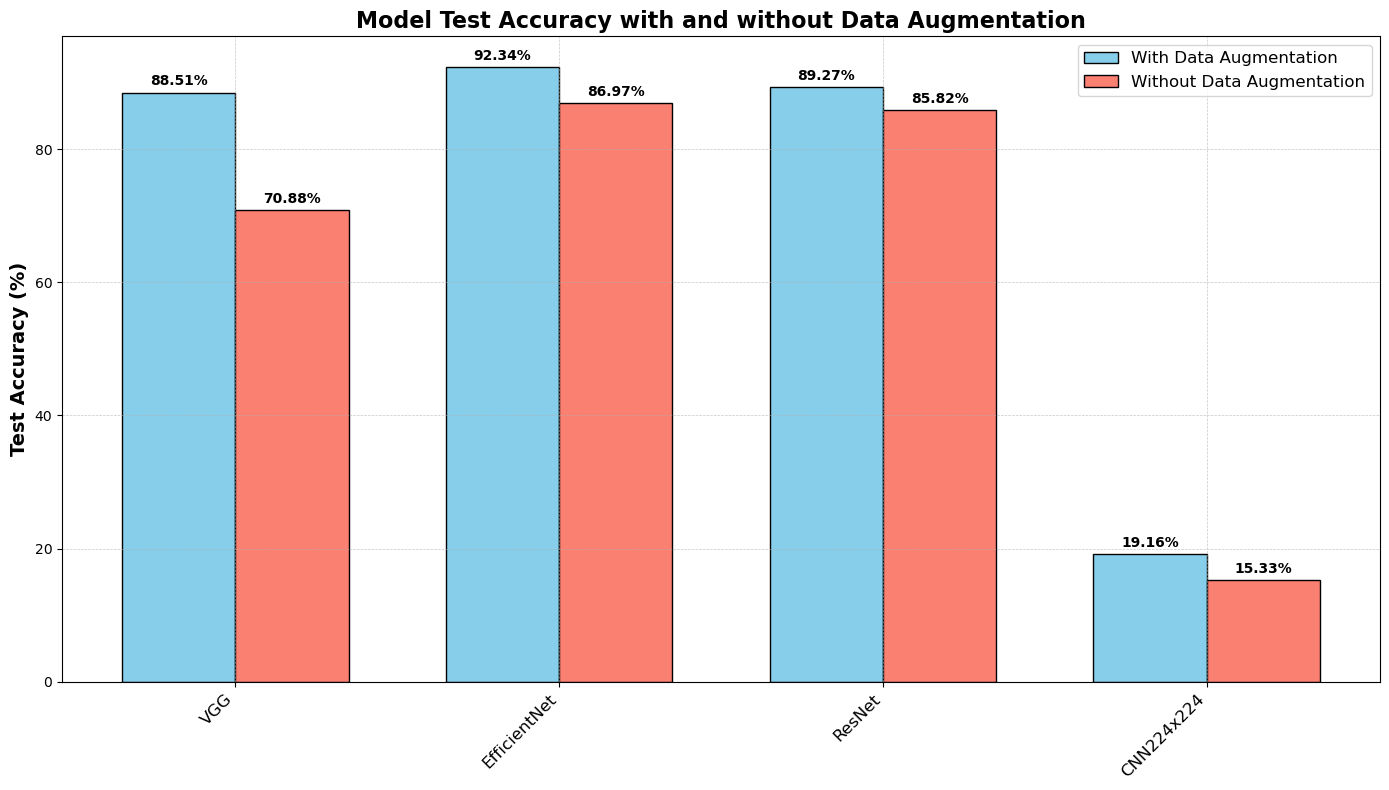

In [296]:
# Extract test accuracies
model_names = list(final_results.keys())
test_accuracies_with = [final_results[model]['with_augmentation']['test_acc'] * 100 for model in model_names]
test_accuracies_without = [final_results[model]['without_augmentation']['test_acc'] * 100 for model in model_names]

x = np.arange(len(model_names))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(14, 8))
rects1 = ax.bar(x - width/2, test_accuracies_with, width, label='With Data Augmentation', color='skyblue', edgecolor='black')
rects2 = ax.bar(x + width/2, test_accuracies_without, width, label='Without Data Augmentation', color='salmon', edgecolor='black')

# Add labels, title, and legend
ax.set_ylabel('Test Accuracy (%)', fontsize=14, weight='bold')
ax.set_title('Model Test Accuracy with and without Data Augmentation', fontsize=16, weight='bold')
ax.set_xticks(x)
ax.set_xticklabels(model_names, rotation=45, ha='right', fontsize=12)
ax.legend(fontsize=12)

# Add labels above the bars
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}%',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3), 
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=10, weight='bold')

autolabel(rects1)
autolabel(rects2)

# Add gridlines
ax.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)

# Make the layout tight
fig.tight_layout()

# Show the plot
plt.show()


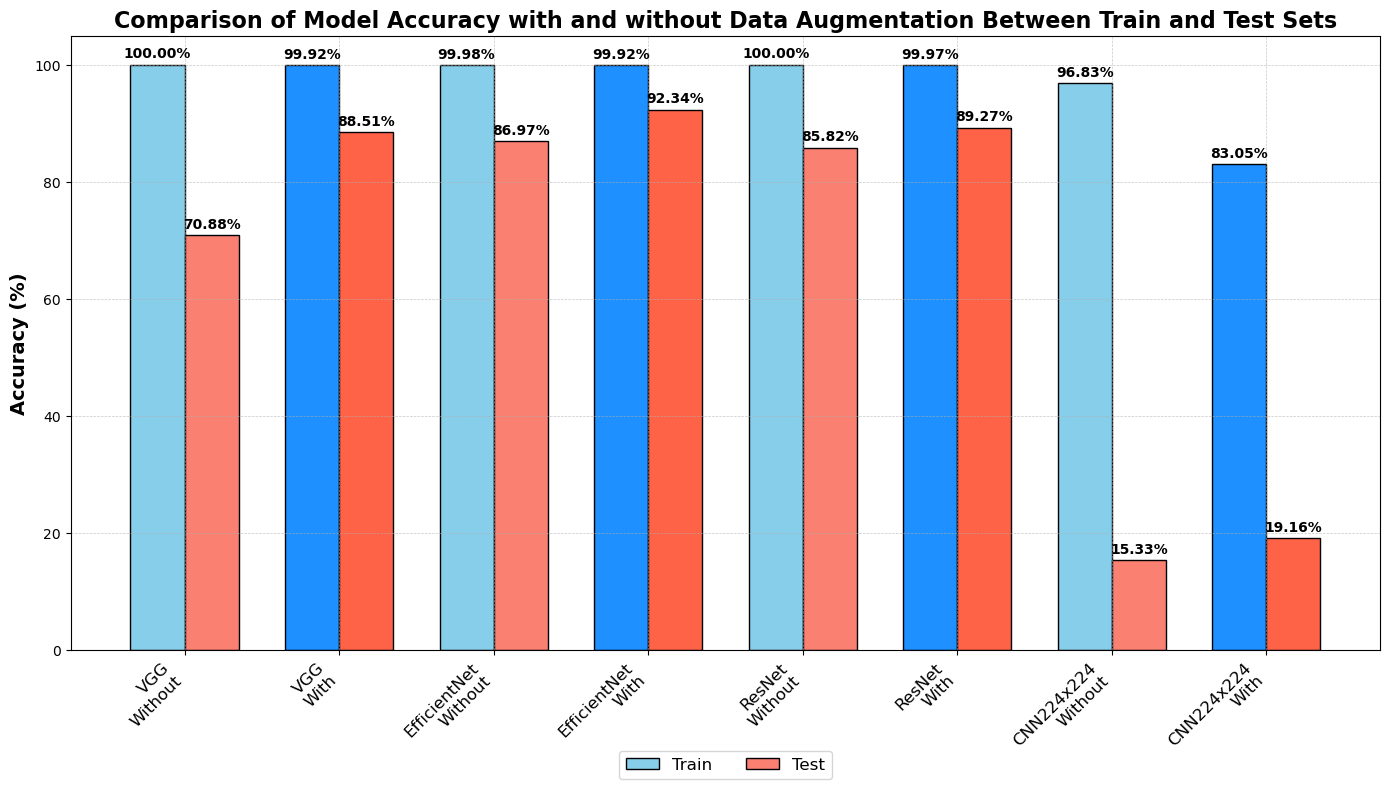

In [308]:
# Extract accuracies for train and test for each model, with and without augmentation
labels = ['VGG', 'EfficientNet', 'ResNet', 'CNN224x224']
x = np.arange(len(labels) * 2)
width = 0.35

train_acc_with = [final_results[model]['with_augmentation']['train_acc'] * 100 for model in labels]
test_acc_with = [final_results[model]['with_augmentation']['test_acc'] * 100 for model in labels]
train_acc_without = [final_results[model]['without_augmentation']['train_acc'] * 100 for model in labels]
test_acc_without = [final_results[model]['without_augmentation']['test_acc'] * 100 for model in labels]

fig, ax = plt.subplots(figsize=(14, 8))

rects1 = ax.bar(x[0::2] - width/2, train_acc_without, width, label='Train', color='skyblue', edgecolor='black')
rects2 = ax.bar(x[0::2] + width/2, test_acc_without, width, label='Test', color='salmon', edgecolor='black')
rects3 = ax.bar(x[1::2] - width/2, train_acc_with, width,   color='dodgerblue', edgecolor='black')
rects4 = ax.bar(x[1::2] + width/2, test_acc_with, width,   color='tomato', edgecolor='black')

ax.set_ylabel('Accuracy (%)', fontsize=14, weight='bold')
ax.set_title('Comparison of Model Accuracy with and without Data Augmentation Between Train and Test Sets', fontsize=16, weight='bold')
ax.set_xticks(x)
ax.set_xticklabels(['VGG\nWithout', 'VGG\nWith', 'EfficientNet\nWithout', 'EfficientNet\nWith', 'ResNet\nWithout', 'ResNet\nWith', 'CNN224x224\nWithout', 'CNN224x224\nWith'], rotation=45, ha='right', fontsize=12)

ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=2, fontsize=12)

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}%', xy=(rect.get_x() + rect.get_width() / 2, height), xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=10, weight='bold')

for rects in [rects1, rects2, rects3, rects4]:
    autolabel(rects)

ax.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
fig.tight_layout()
plt.show()


**Why Data Augmentation Boosts CNN Performance**
- Combat Overfitting: Augmentation artificially expands the dataset (like simulating poor lighting or folded bills), forcing the model to learn robust features.

- Mimicking Real-World Conditions: Since test images included partial/folded bills, augmentation trained the model to focus on local features  rather than relying on perfect shots.

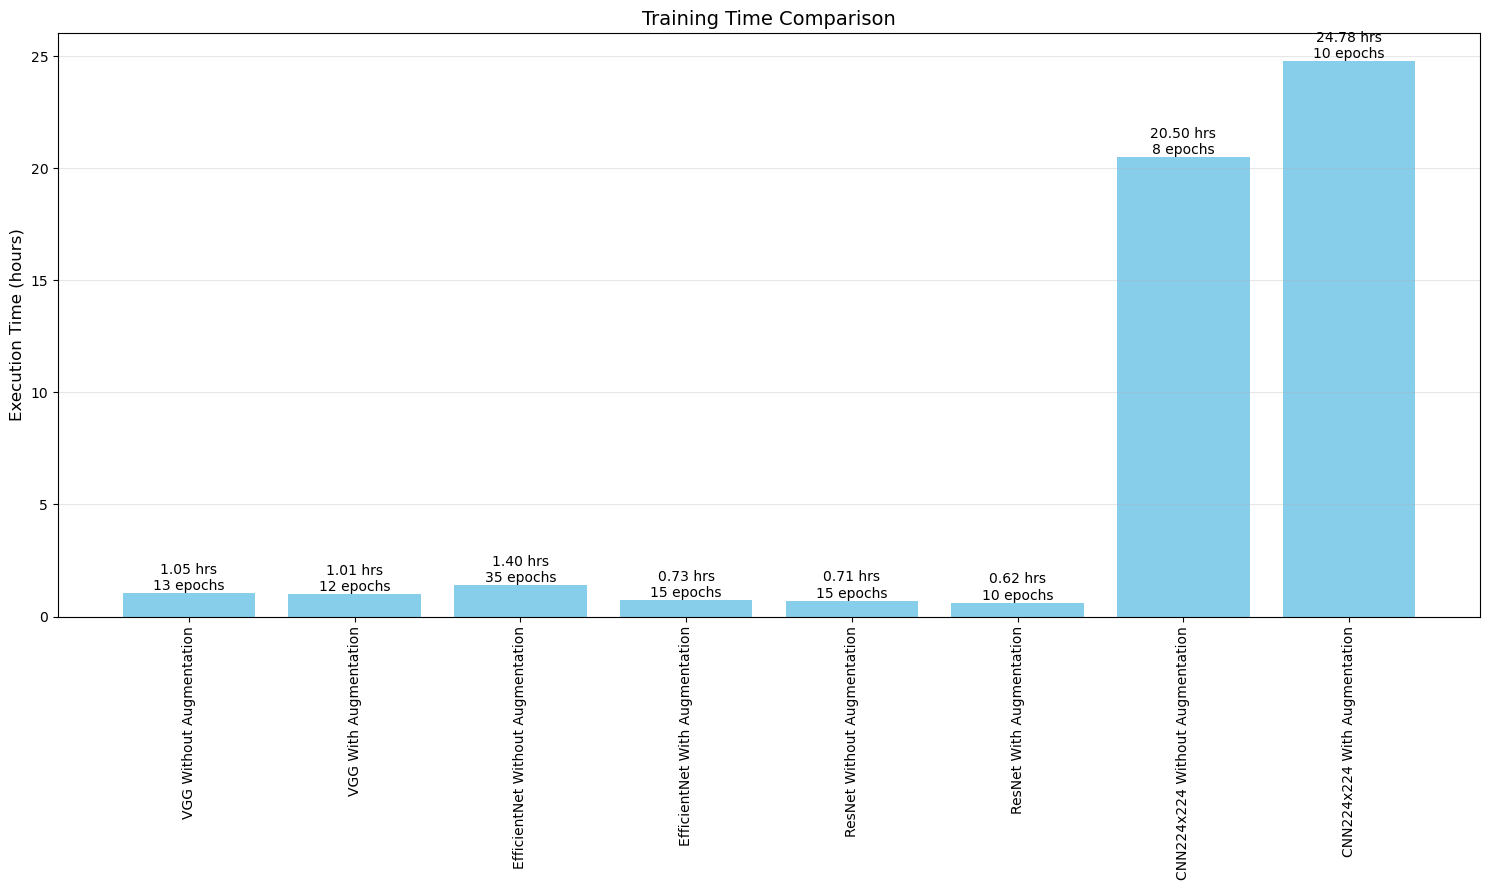

In [310]:
# Extract the training times and number of epochs
execution_times = {
    'VGG Without Augmentation': final_results['VGG']['without_augmentation']['training_time'],
    'VGG With Augmentation': final_results['VGG']['with_augmentation']['training_time'],
    'EfficientNet Without Augmentation': final_results['EfficientNet']['without_augmentation']['training_time'],
    'EfficientNet With Augmentation': final_results['EfficientNet']['with_augmentation']['training_time'],
    'ResNet Without Augmentation': final_results['ResNet']['without_augmentation']['training_time'],
    'ResNet With Augmentation': final_results['ResNet']['with_augmentation']['training_time'],
    'CNN224x224 Without Augmentation': final_results['CNN224x224']['without_augmentation']['training_time'],
    'CNN224x224 With Augmentation': final_results['CNN224x224']['with_augmentation']['training_time']
}

# Extract the number of epochs
epochs = {
    'VGG Without Augmentation': final_results['VGG']['without_augmentation']['stop_epoch'],
    'VGG With Augmentation': final_results['VGG']['with_augmentation']['stop_epoch'],
    'EfficientNet Without Augmentation': final_results['EfficientNet']['without_augmentation']['stop_epoch'],
    'EfficientNet With Augmentation': final_results['EfficientNet']['with_augmentation']['stop_epoch'],
    'ResNet Without Augmentation': final_results['ResNet']['without_augmentation']['stop_epoch'],
    'ResNet With Augmentation': final_results['ResNet']['with_augmentation']['stop_epoch'],
    'CNN224x224 Without Augmentation': final_results['CNN224x224']['without_augmentation']['stop_epoch'],
    'CNN224x224 With Augmentation': final_results['CNN224x224']['with_augmentation']['stop_epoch']
}

labels = list(execution_times.keys())

# Generate the execution time comparison chart
plt.figure(figsize=(15, 9))
bars = plt.bar(labels, [t / 3600 for t in execution_times.values()], color='skyblue')

# Add exact time and number of epochs labels
for bar, label in zip(bars, labels):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2., height, f'{height:.2f} hrs\n{epochs[label]} epochs', ha='center', va='bottom')

plt.ylabel('Execution Time (hours)', fontsize=12)
plt.title('Training Time Comparison', fontsize=14)
plt.xticks(rotation=90)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()


**Why EfficientNet Outshines ResNet, VGG, and Custom Models?**

- Efficiency: EfficientNet’s compound scaling optimizes depth, width, and resolution simultaneously, achieving higher accuracy with fewer parameters.

- Generalization: Pre-trained on ImageNet, it adapts better to small datasets (7k training images) compared to heavier models like VGG16.

- Custom Model Limitations: My initial CNN lacked the hierarchical feature extraction capability of EfficientNet, leading to underfitting on complex patterns (e.g., texture differences between old/new banknotes).

## Evaluation of the best model's metrics.

In [313]:
# Define paths and variables
BASE_PATH_MODELS = "/Users/elvisrojasmonguia/Documents/Python courses/Projects/Peruvian banknotes/models"
BEST_MODEL_SAVED_PATH = f"{BASE_PATH_MODELS}/with_augmentation/"
print(BEST_MODEL_SAVED_PATH)

# Find the best model based on test accuracy
best_model_name = None
best_model = None
best_accuracy = 0

for model_name, model_results in final_results.items():
    for augmentation, results in model_results.items():
        if results['test_acc'] > best_accuracy:
            best_accuracy = results['test_acc']
            best_model = model_name
            best_model_name = f"{model_name}_{augmentation}"

print(f"The best model is: {best_model_name} with a test accuracy of {best_accuracy:.2%}")


/Users/elvisrojasmonguia/Documents/Python courses/Projects/Peruvian banknotes/models/with_augmentation/
The best model is: EfficientNet_with_augmentation with a test accuracy of 92.34%


In [140]:

# Load the best model
best_model_base_name = best_model_name.split('_')[0]  # Get the base name of the model
best_model_path = f"{BEST_MODEL_SAVED_PATH}best_model_{best_model}.pth"
BEST_MODEL_FUNCTION = initialize_model(best_model_base_name)  # Initialize the model

print(best_model_path)
BEST_MODEL_FUNCTION.load_state_dict(torch.load(best_model_path))
BEST_MODEL_FUNCTION.to(device)
BEST_MODEL_FUNCTION.eval()
 

/Users/elvisrojasmonguia/Documents/Python courses/Projects/Peruvian banknotes/models/with_augmentation/
The best model is: EfficientNet_with_augmentation with a test accuracy of 92.34%
/Users/elvisrojasmonguia/Documents/Python courses/Projects/Peruvian banknotes/models/with_augmentation/best_model_EfficientNet.pth


/var/folders/fk/v7c5p8wn1knfy26l727g3py40000gn/T/ipykernel_1078/3538094089.py:25: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  BEST_MODEL_FUNCTION.load_state_dict(torch.loa

In [ ]:
loaders, class_weights = load_datasets_cached(apply_augmentation=True)

In [169]:
# Evaluate the best model on the test set and find misclassified images
all_predictions = []
all_probabilities = []
all_true_labels = []
misclassified_images = []
misclassified_true_labels = []
misclassified_predicted_labels = []

with torch.no_grad():
    for images, labels in tqdm(loaders['test'], desc="Evaluating model"):
        images, labels = images.to(device), labels.to(device)
        outputs = BEST_MODEL_FUNCTION(images)
        probabilities = torch.softmax(outputs, dim=1)
        _, predicted = torch.max(outputs, 1)
        
        # Store general results
        all_predictions.append(predicted.cpu())
        all_probabilities.append(probabilities.cpu())
        all_true_labels.append(labels.cpu())
        
        # Identify misclassified images
        misclassified_mask = (predicted != labels)
        if misclassified_mask.any():
            misclassified_images.append(images[misclassified_mask].cpu())
            misclassified_true_labels.append(labels[misclassified_mask].cpu())
            misclassified_predicted_labels.append(predicted[misclassified_mask].cpu())

# Convert lists to numpy arrays
all_predictions = torch.cat(all_predictions).numpy()
all_probabilities = torch.cat(all_probabilities).numpy()
all_true_labels = torch.cat(all_true_labels).numpy()
misclassified_images = torch.cat(misclassified_images).numpy()
misclassified_true_labels = torch.cat(misclassified_true_labels).numpy()
misclassified_predicted_labels = torch.cat(misclassified_predicted_labels).numpy()

# Show some statistics
print(f"Number of test samples: {len(all_true_labels)}")
print(f"Prediction accuracy: {(all_predictions == all_true_labels).mean():.2%}")


Evaluating model: 100%|███████████████████████████| 9/9 [00:03<00:00,  2.49it/s]

Number of test samples: 261
Prediction accuracy: 92.34%


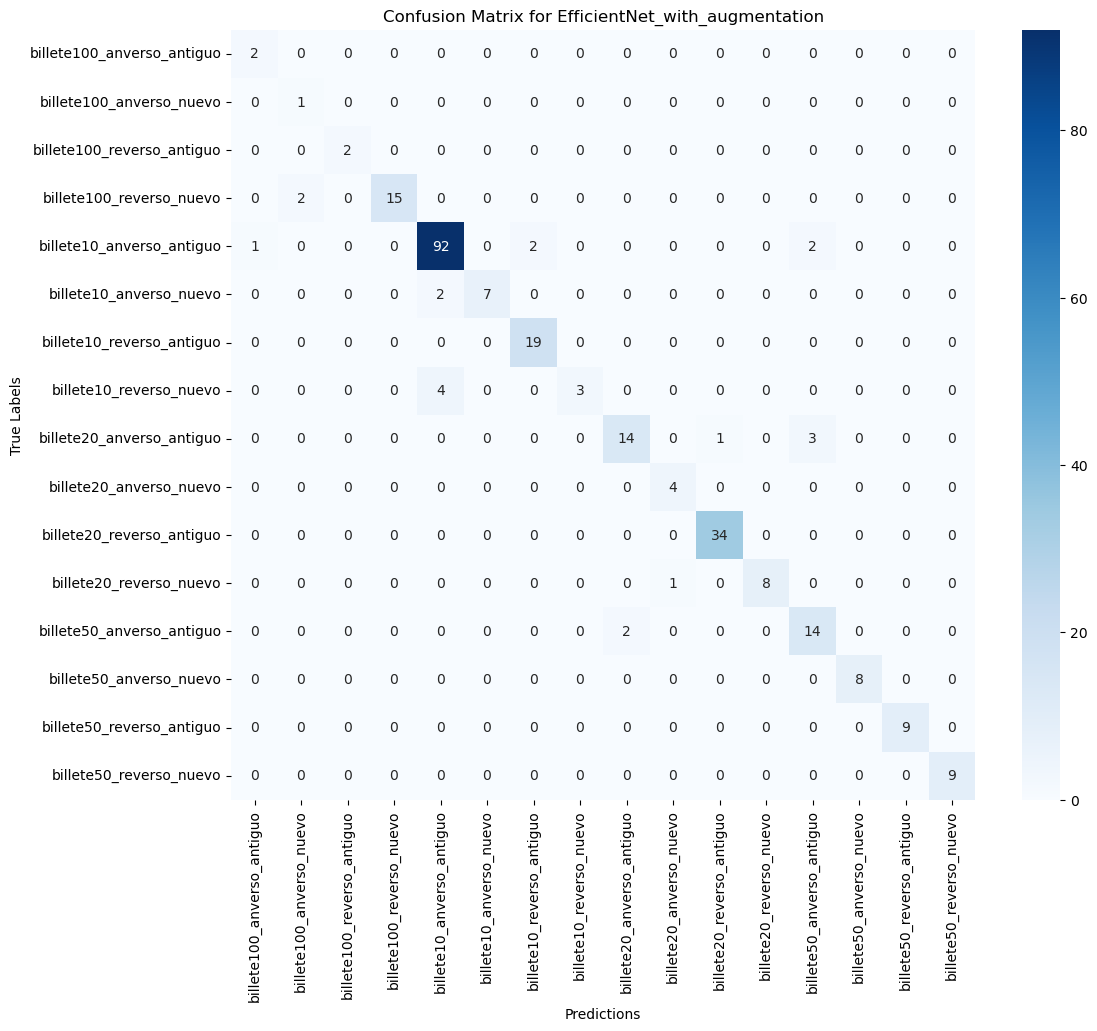

In [171]:
# Generate the confusion matrix
cm = confusion_matrix(all_true_labels, all_predictions)

# Plot the confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',  # Format as integers
    cmap='Blues',  # Color map
    xticklabels=class_names,  # Class names for x-axis
    yticklabels=class_names   # Class names for y-axis
)
plt.xlabel('Predictions')
plt.ylabel('True Labels')
plt.title(f'Confusion Matrix for {best_model_name}')
plt.show()

In [315]:
# Function to denormalize images
def denormalize(image, mean, std):
    image = image.copy()
    for i in range(image.shape[0]):
        image[i] = image[i] * std[i] + mean[i]
    return image

# Function to visualize misclassified images
def plot_misclassified_images(images, true_labels, predicted_labels, class_names, num_images, fig_size_tup=(25, 25)):
    plt.figure(figsize=fig_size_tup)
    rows = int(np.ceil(num_images / 5))
    gs = gridspec.GridSpec(rows, 5, wspace=0.4, hspace=0.4)
    
    for i in range(min(num_images, len(images))):
        ax = plt.subplot(gs[i])
        
        # Denormalize and convert image tensor to proper format for plotting
        img = denormalize(images[i], NORMALIZATION_MEAN, NORMALIZATION_STD).transpose(1, 2, 0)  # Change from (C, H, W) to (H, W, C)
        if img.shape[2] == 1:  # Handle grayscale images
            img = img.squeeze()
        
        # Ensure values are in the proper range
        img = np.clip(img, 0, 1)
        
        # Plot the image
        ax.imshow(img, cmap='gray' if img.ndim == 2 else None)
        
        # Add title with true and predicted labels
        true_class = class_names[true_labels[i]]
        predicted_class = class_names[predicted_labels[i]]
        ax.set_title(f"True: {true_class}\nPredicted: {predicted_class}", fontsize=12)
        ax.axis('off')
    
    plt.subplots_adjust(wspace=0.3, hspace=0.3)  # Manually adjust spacing
    plt.show()


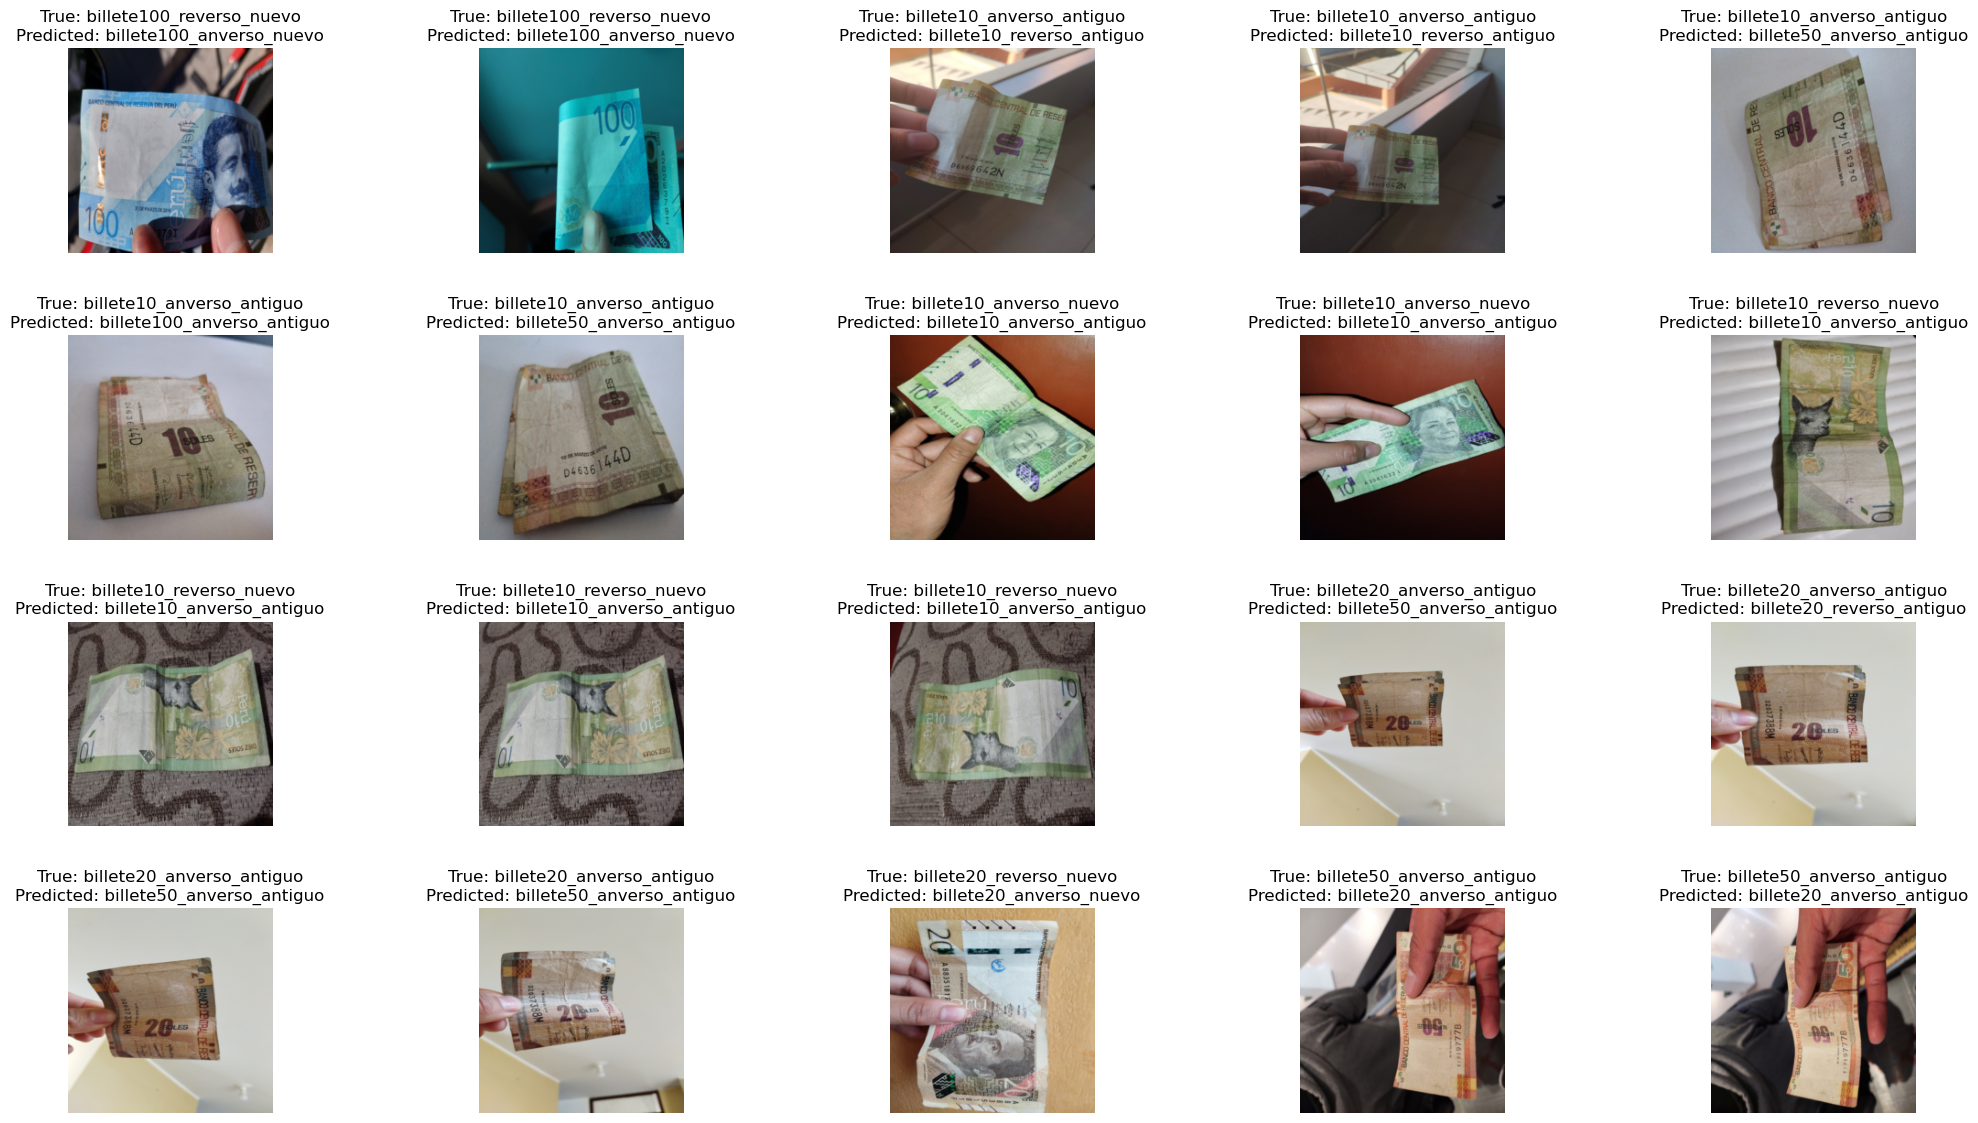

In [317]:

# Plot the misclassified images
plot_misclassified_images(
    misclassified_images,
    misclassified_true_labels,
    misclassified_predicted_labels,
    class_names,
    num_images=35,  # Number of misclassified images to show
    fig_size_tup=(25, 25)  # Increase overall figure size
)


**Why the Model Confuses 20/50 and 10/100 Soles**
Visual Similarities:

- 20 vs. 50 Soles: Both new-family bills share color palettes  and design elements.

- 10 vs. 100 Soles: Similar sizes and dominant colors  in older series.

- Partial Occlusion: If key discriminative features are cropped, the model relies on less reliable patterns.





## Measuring Performance for generalized Banknote Denominations

In [214]:
# Mapping complete classes to denominations
class_to_denomination = {
    "billete10_anverso_antiguo": 10,
    "billete10_anverso_nuevo": 10,
    "billete10_reverso_antiguo": 10,
    "billete10_reverso_nuevo": 10,

    "billete20_anverso_antiguo": 20,
    "billete20_anverso_nuevo": 20,
    "billete20_reverso_antiguo": 20,
    "billete20_reverso_nuevo": 20,

    "billete50_anverso_antiguo": 50,
    "billete50_anverso_nuevo": 50,
    "billete50_reverso_antiguo": 50,
    "billete50_reverso_nuevo": 50,

    "billete100_anverso_antiguo": 100,
    "billete100_anverso_nuevo": 100,
    "billete100_reverso_antiguo": 100,
    "billete100_reverso_nuevo": 100
} 

In [226]:
# Map class indices to class labels
y_classes_info = {v: k for k, v in loaders['test'].dataset.class_to_idx.items()} 

# Get predicted class labels
y_predicted_classes = [y_classes_info[i] for i in all_predictions]

# Map predicted class labels to denominations
y_predicted_less_classes = [class_to_denomination[cls] for cls in y_predicted_classes]
 
# Get the true labels
y_true_labels = [y_classes_info[i] for i in all_true_labels]

# Map true labels to denominations
y_true_denominations = [class_to_denomination[label] for label in y_true_labels]



Accuracy for general denominations: 0.97



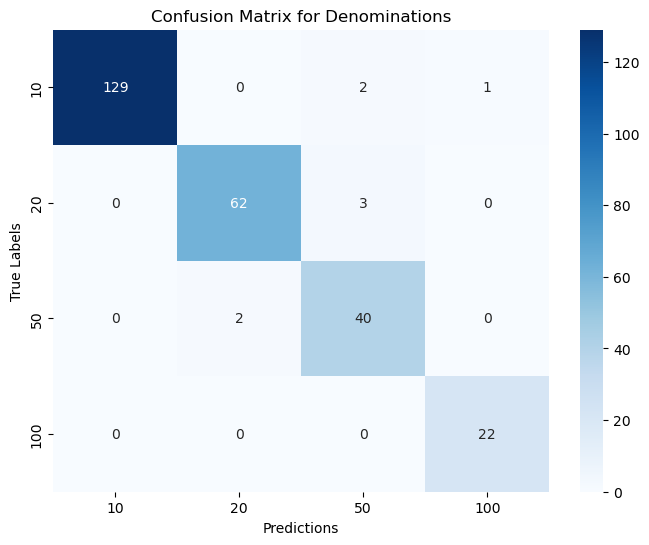

In [242]:
# Calculate accuracy
accuracy = accuracy_score(y_true_denominations, y_predicted_less_classes)
print(f"\nAccuracy for general denominations: {accuracy:.2f}\n")

# Confusion matrix
cm = confusion_matrix(y_true_denominations, y_predicted_less_classes, labels=[10, 20, 50, 100])
plt.figure(figsize=(8, 6))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=["10", "20", "50", "100"], 
            yticklabels=["10", "20", "50", "100"])

plt.xlabel('Predictions')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for Denominations')
plt.show()
